# Machine Learning Worflow

The stages and workflows that are involved in Machine Learning projects are evolving as the field and technology itself develops. But there are standard steps that you should follow for a data science project.

![title](./images/ml_workflow.png)

Let's get started and implement each step one by one to solve our problem.

## Defining The Problem and Proposing A Solution

### Calculating the Probability of Future Customer Engagement
In non-subscription retail models, customers come and go with no long-term commitments, making it very difficult to determine whether a customer will return in the future. Determining the probability that a customer will re-engage is critical to the design of effective marketing campaigns. Different messaging and promotions may be required to incentivize customers who have likely dropped out to return to our stores. Engaged customers may be more responsive to marketing that encourages them to expand the breadth and scale of purchases with us. Understanding where our customers land with regard to the probability of future engagement is critical to tailoring our marketing efforts to them.

The *Buy til You Die (BTYD)* models popularized by Peter Fader and others leverage two basic customer metrics, i.e. the recency of a customer's last engagement and the frequency of repeat transactions over a customer's lifetime, to derive a probability of future re-engagement. This is done by fitting customer history to curves describing the distribution of purchase frequencies and engagement drop-off following a prior purchase. 
The math behind these models is fairly complex but thankfully it's been encapsulated in the lifetimes library, making it much easier for traditional enterprises to employ. The purpose of this notebook is to examine how these models may be applied to customer transaction history and how they may be deployed for integration in marketing processes.

## Construct the dataset and Transform data

### Importing required packages and read the prepared data

In [1]:
import pandas as pd
from matplotlib import rcParams
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_palette('coolwarm')
sns.set(rc= {'image.cmap': 'coolwarm'})
rcParams['figure.figsize'] = 15,10
sns.set(rc={'figure.figsize':(15,10)})


# Loading the dataset
df= pd.read_csv("data/deposits.csv")
df.head()

,transaction_id,transaction_time,user_id,amount_usd
0,11000,12/1/10 8:26,17850.0,15.30
1,11001,12/1/10 8:26,17850.0,20.34
2,11002,12/1/10 8:26,17850.0,22.00
3,11003,12/1/10 8:26,17850.0,20.34
4,11004,12/1/10 8:26,17850.0,20.34


In [2]:
# checking the shape of the data
print(df.shape)

(541909, 4)


In [3]:
df.dtypes

transaction_id        int64
transaction_time     object
user_id             float64
amount_usd          float64
dtype: object

### Fixing data types

In [4]:
import datetime as dt
df.dropna(subset=['user_id', 'transaction_id'],inplace=True)
df['user_id']=df['user_id'].astype(int)
df['transaction_time'] =  pd.to_datetime(df['transaction_time'])
df['transaction_date'] =  pd.to_datetime(df['transaction_time']).dt.date
df.head()

,transaction_id,transaction_time,user_id,amount_usd,transaction_date
0,11000,2010-12-01 08:26:00,17850,15.30,2010-12-01
1,11001,2010-12-01 08:26:00,17850,20.34,2010-12-01
2,11002,2010-12-01 08:26:00,17850,22.00,2010-12-01
3,11003,2010-12-01 08:26:00,17850,20.34,2010-12-01
4,11004,2010-12-01 08:26:00,17850,20.34,2010-12-01


### Exploratory Data Analysis (EDA)

Checking transaction activity in the dataset. The daily transaction count shows there is quite a bit of volatility in daily activity of our customers.

<AxesSubplot:xlabel='transaction_date'>

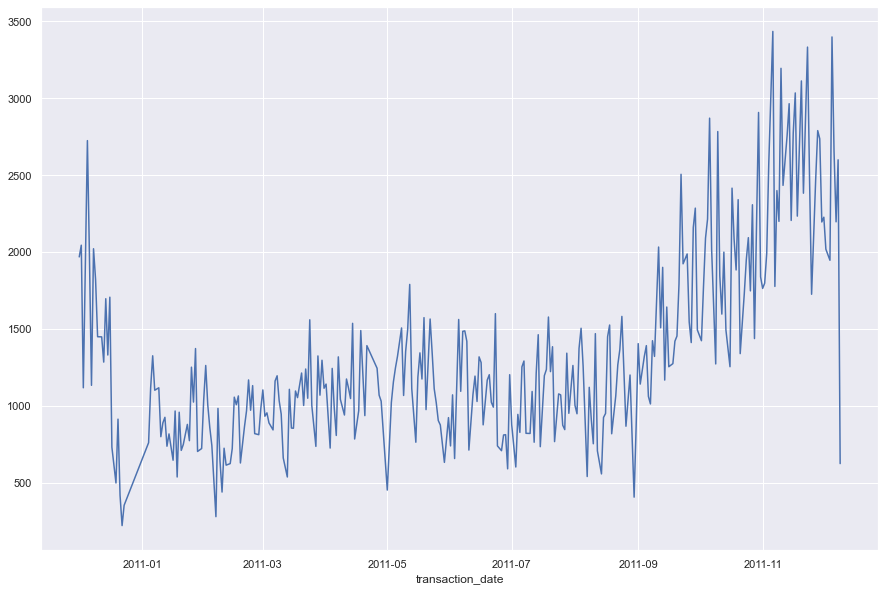

In [5]:
df.groupby('transaction_date').transaction_id.nunique().plot()

Let's smooth this chart out by summarizing it by month to get a better picture of changes.

<AxesSubplot:xlabel='transaction_time'>

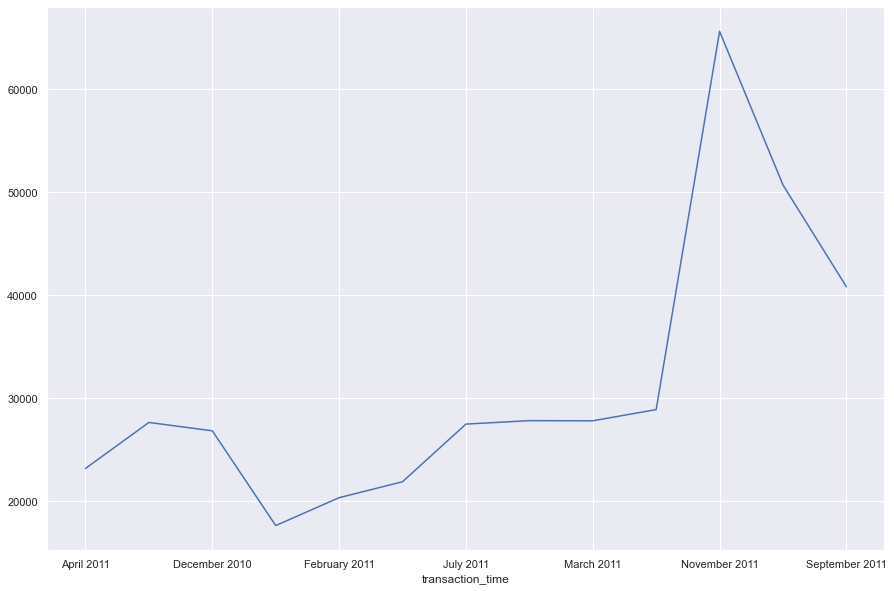

In [6]:
df.groupby(df['transaction_time'].dt.strftime('%B %Y')).transaction_id.nunique().plot()

How many customers was engaged with the company and how many transactions was accompolished during the date range.

In [7]:
print(df['user_id'].nunique())
print(df['transaction_id'].nunique())

4372
406829


let's count unique transactions by customer and then plot the frequncy of these values. As you can see many of customers just did one sigle transaction.

<AxesSubplot:ylabel='Frequency'>

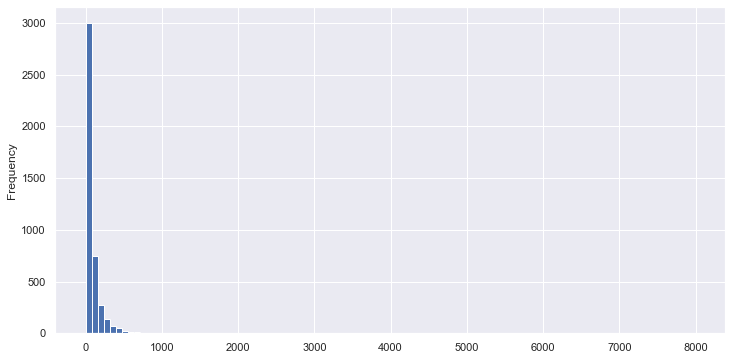

In [8]:
df.groupby('user_id').agg(
    occurrenece=('transaction_id','nunique')
    ).reset_index()['occurrenece'].plot(kind='hist',bins=100,color='b',figsize=(12,6))

If we alter our last analysis to group a customer's transactions that occur on the same date into a single transaction - a pattern that aligns with metrics we will calculate later - we see that a few more customers are identified as non-repeat customers but the overall pattern remains the same:

<AxesSubplot:ylabel='Frequency'>

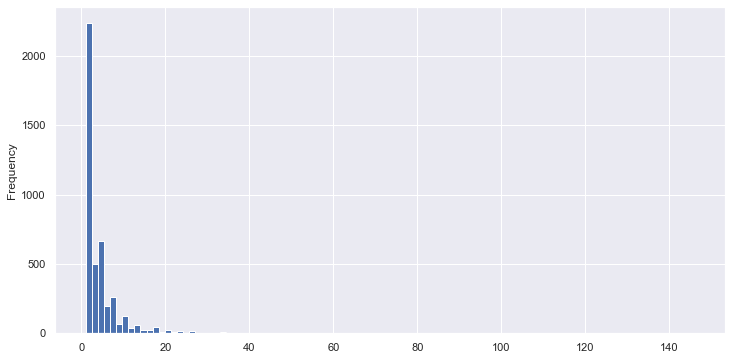

In [9]:
df.groupby(['user_id']).agg(
    occurrence=('transaction_date','nunique')
    ).reset_index()['occurrence'].plot(kind='hist',bins=100,color='b',figsize=(12,6))

The distribution of the count of repeat purchases declines from there in a manner that we may describe as negative binomial distribution (which is the basis of the NBD acronym included in the name of most BTYD models)

Focusing on customers with repeat purchases, we can examine the distribution of the days between purchase events.

In [10]:
df_dist=df[['user_id','transaction_date']].drop_duplicates()

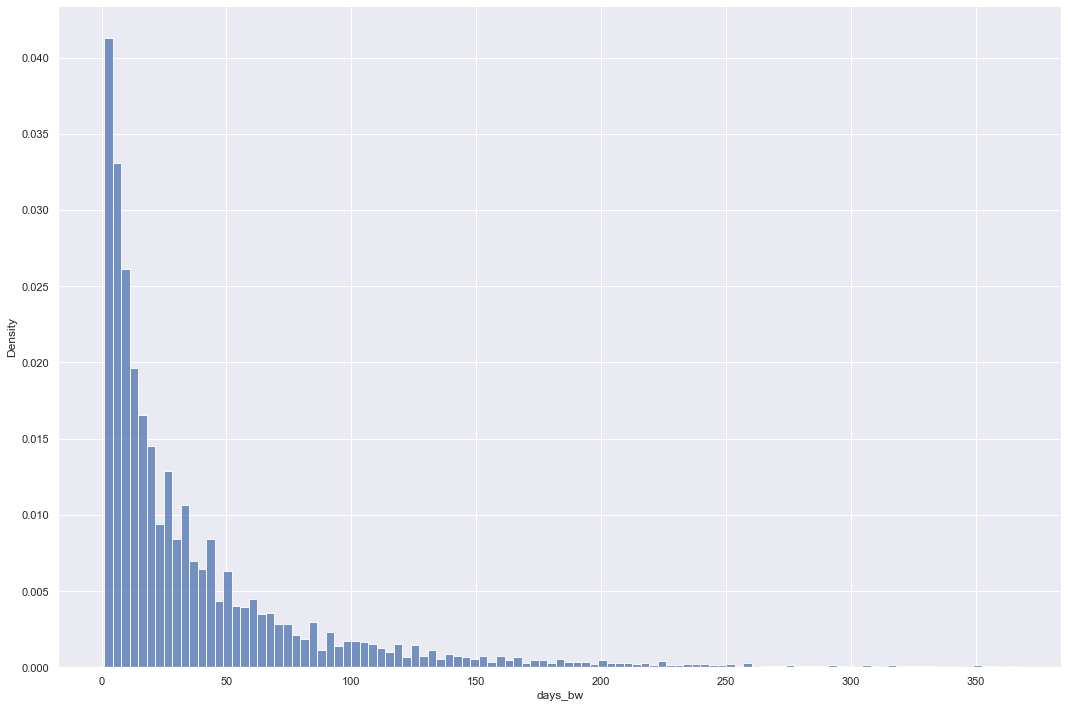

In [11]:
df_dist['previous_transaction'] = df_dist.groupby(['user_id'])['transaction_date'].shift()
df_dist['days_bw'] = df['transaction_date'] - df_dist['previous_transaction']
df_dist['days_bw'] = df_dist['days_bw'].apply(lambda x: x.days)
sns.displot(x=df_dist['days_bw'],stat='density',height=10, aspect=1.5)

What's important to note here is that most customers return to the site within 2 to 3 months of a prior purchase. Longer gaps do occur but significantly fewer customers have longer gaps between returns. This is important to understand in the context of our BYTD models in that the time since we last saw a customer is a critical factor to determining whether they will ever come back with the probability of return dropping as more and more time passes since a customer's last purchase event.

###  Importing lifetimes package to view our data into RFM metrics

The dataset with which we are working consists of raw transactional history. To apply the BTYD models, we need to derive several per-customer metrics:

`frequency` represents the number of repeat purchases the customer has made. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

`T` represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

`recency` represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)

`monetary_value` represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

To calculate these metrics there are built-in functions in liftimes library.

In [12]:
import lifetimes
current_date=df['transaction_date'].max()
metrics_df = lifetimes.utils.summary_data_from_transaction_data(df, 'user_id','transaction_date', monetary_value_col = 'amount_usd', observation_period_end = current_date)
metrics_df.head(10)

,frequency,recency,T,monetary_value
user_id,,,,
12346,0.0,0.0,325.0,0.000000
12347,6.0,365.0,367.0,599.701667
12348,3.0,283.0,358.0,301.480000
12349,0.0,0.0,18.0,0.000000
12350,0.0,0.0,310.0,0.000000
12352,6.0,260.0,296.0,528.361667
12353,0.0,0.0,204.0,0.000000
12354,0.0,0.0,232.0,0.000000
12355,0.0,0.0,214.0,0.000000


In [13]:
metrics_df.describe()

,frequency,recency,T,monetary_value
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,3.413541,133.723010,225.304209,322.707519
std,6.674343,133.000474,118.384168,5152.989562
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,115.000000,0.000000
50%,1.000000,98.000000,253.000000,160.166250
75%,4.000000,256.000000,331.000000,316.732500
max,145.000000,373.000000,373.000000,336939.200000


##  Train-Test Split

The train-test split is a technique for evaluating the performance of a machine learning algorithm.

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.

`Train Dataset`: Used to fit the machine learning model.

`Test Dataset` : Used to evaluate the fit machine learning model.

![image info](./images/train-test.png)

 With transactional data, we can partition the dataset into a calibration period dataset and a holdout dataset. This is important as we want to test how our model performs on data not yet seen (think train-test in standard machine learning literature). Lifetimes has a function to partition our dataset like this

In [14]:
holdout_days = 90
calibration_end_date= current_date - dt.timedelta(days=holdout_days)
metrics_cal_df=lifetimes.utils.calibration_and_holdout_data(
    df,
    customer_id_col='user_id',
    datetime_col='transaction_date',
    observation_period_end = current_date,
    calibration_period_end=calibration_end_date,
    freq='D'    
)
metrics_cal_df.head(10)

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
12346,0.0,0.0,235.0,0.0,90.0
12347,4.0,238.0,277.0,2.0,90.0
12348,2.0,110.0,268.0,1.0,90.0
12350,0.0,0.0,220.0,0.0,90.0
12352,3.0,34.0,206.0,3.0,90.0
12353,0.0,0.0,114.0,0.0,90.0
12354,0.0,0.0,142.0,0.0,90.0
12355,0.0,0.0,124.0,0.0,90.0
12356,1.0,80.0,235.0,1.0,90.0


In [15]:
metrics_cal_df.describe()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
count,3412.000000,3412.000000,3412.000000,3412.000000,3412.0
mean,2.677608,90.587046,185.041618,1.502345,90.0
std,5.222838,96.077761,80.771943,2.495318,0.0
min,0.000000,0.000000,1.000000,0.000000,90.0
25%,0.000000,0.000000,125.000000,0.000000,90.0
50%,1.000000,59.500000,197.000000,1.000000,90.0
75%,3.000000,175.000000,268.000000,2.000000,90.0
max,93.000000,282.000000,283.000000,52.000000,90.0


The last thing we need to do is exclude customers for which we have no repeat purchases, i.e. frequency or frequency_cal is 0. The Pareto/NBD and BG/NBD models we will use focus exclusively on performing calculations on customers with repeat transactions. A modified BG/NBD model, i.e. MBG/NBD, which allows for customers with no repeat transactions is supported by the lifetimes library. However, to stick with the two most popular of the BYTD models in use today, we will limit our data to align with their requirements:

In [16]:
# remove customers with no repeats (complete dataset)
filtered_df = metrics_df[metrics_df['frequency'] > 0]

## remove customers with no repeats in calibration period
filtered_cal_df = metrics_cal_df[metrics_cal_df['frequency_cal'] > 0]

## Fitting/Training the model

 we have two models that we could use here: the Pareto/NBD model and the BG/NBD model. The BG/NBD model simplifies the math involved in calculating customer lifetime and is the model that popularized the BTYD approach. Both models work off the same customer features and employ the same constraints. (The primary difference between the two models is that the BG/NBD model maps the survivorship curve to a beta-geometric distribution instead of a Pareto distribution.) 

Each model leverages an L2-norm regularization parameter which we've arbitrarily set to 0 in the previous training cycle.

Regularization parameter regularizes or shrinks the coefficient estimates towards zero. In other words, this technique discourages learning a more complex or flexible model, so as to avoid the risk of overfitting.

In [17]:
from lifetimes import BetaGeoFitter

bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(filtered_cal_df['frequency_cal'],filtered_cal_df['recency_cal'],filtered_cal_df['T_cal'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 2163 subjects, a: 0.09, alpha: 95.54, b: 0.55, r: 2.28>


,coef,se(coef),lower 95% bound,upper 95% bound
r,2.275392,0.103232,2.073058,2.477726
alpha,95.542878,4.737910,86.256574,104.829182
a,0.093539,0.015787,0.062596,0.124482
b,0.547570,0.105325,0.341133,0.754007


## Evaluating/Validating the model

There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters.

<AxesSubplot:title={'center':'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

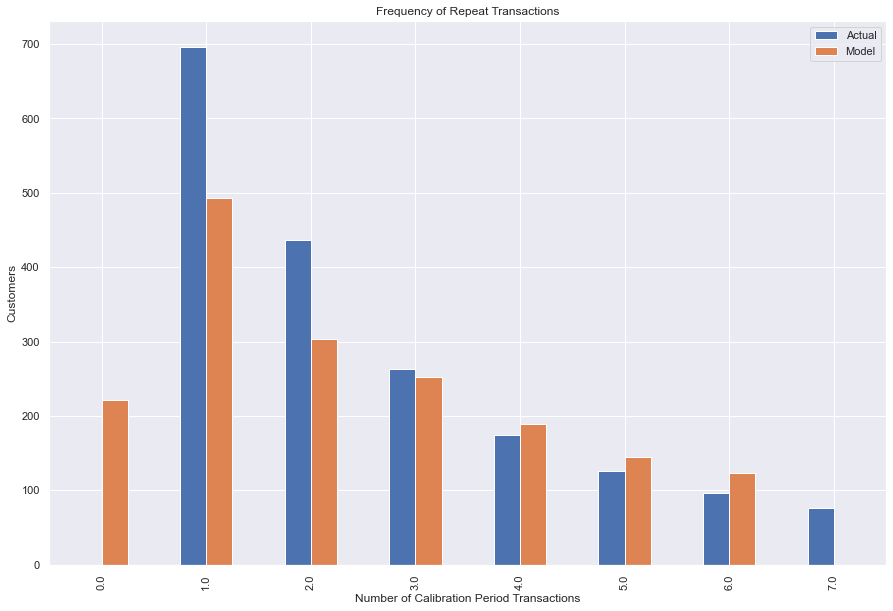

In [18]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

another way to avaluate model

In [19]:
frequency_holdout_predicted = bgf.predict(
    filtered_cal_df['duration_holdout'],
    filtered_cal_df['frequency_cal'],
    filtered_cal_df['recency_cal'],
    filtered_cal_df['T_cal'])

In [20]:
frequency_holdout_actual = filtered_cal_df['frequency_holdout']

With actual and predicted values in hand, we can calculate some standard evaluation metrics. Let's wrap those calculations in a function call to make evaluation easier in future steps:

### Mean Squared Error (MSE)
Measures the average of the squares of the errors

![image info](./images/mse.png)


In [21]:
import numpy as np

def score_model(actuals, predicted, metric='mse'):
  # make sure metric name is lower case
  metric = metric.lower()
  
  # Mean Squared Error and Root Mean Squared Error
  if metric=='mse' or metric=='rmse':
    val = np.sum(np.square(actuals-predicted))/actuals.shape[0]
    if metric=='rmse':
        val = np.sqrt(val)
  
  # Mean Absolute Error
  elif metric=='mae':
    np.sum(np.abs(actuals-predicted))/actuals.shape[0]
  
  else:
    val = None
  
  return val

# score the model
print('MSE: {0}'.format(score_model(frequency_holdout_actual, frequency_holdout_predicted, 'mse')))

MSE: 4.027424975706059


While important for comparing models, the MSE metric is a bit more challenging to interpret in terms of the overall goodness of fit of any individual model. To provide more insight into how well our model fits our data, let's visualize the relationships between some actual and predicted values.

To get started, we can examine **how purchase frequencies in the calibration period relates to actual (frequency_holdout) and predicted (model_predictions) frequencies in the holdout period**:

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

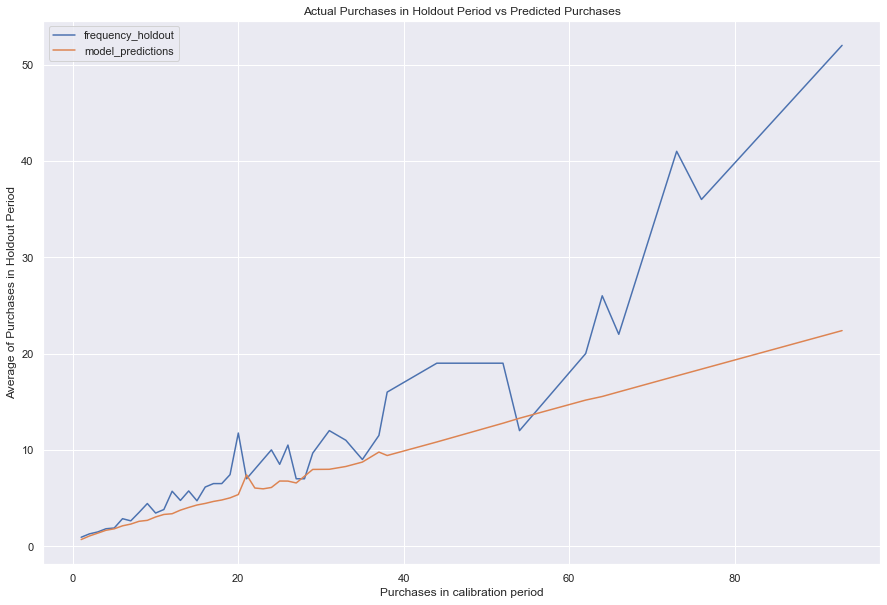

In [22]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(
  bgf, 
  filtered_cal_df, 
  n=90, 
  )

What we see here is that a higher number of purchases in the calibration period predicts a higher average number of purchases in the holdout period but the actual values diverge sharply from model predictions when we consider customers with a large number of purchases (>60) in the calibration period. Thinking back to the charts in the data exploration section of this notebook, you might recall that there are very few customers with such a large number of purchases so that this divergence may be a result of a very limited number of instances at the higher end of the frequency range. More data may bring the predicted and actuals back together at this higher end of the curve

Using the same method call, we can visualize time since last purchase relative to the average number of purchases in the holdout period. 

<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Time since user made last purchase', ylabel='Average of Purchases in Holdout Period'>

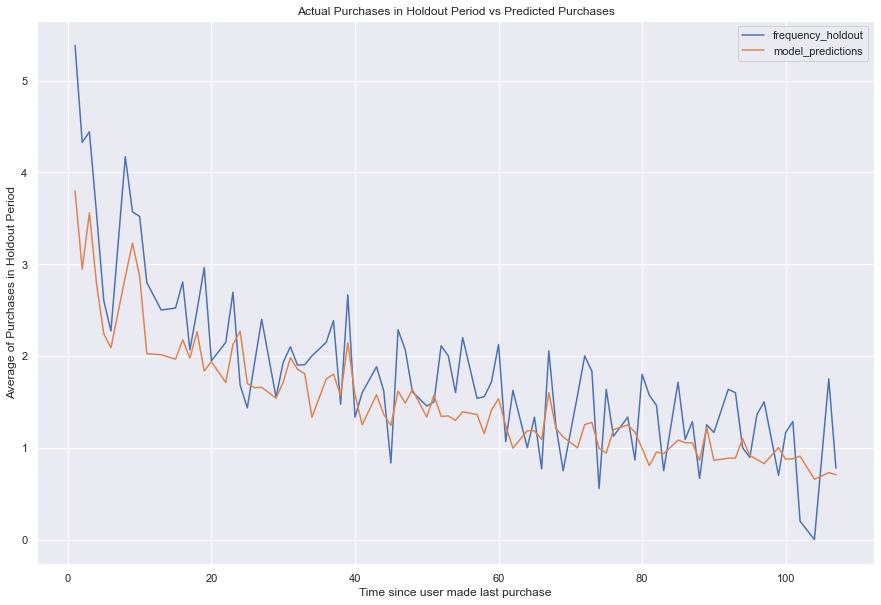

In [23]:
plot_calibration_purchases_vs_holdout_purchases(
  bgf, 
  filtered_cal_df,
  kind='time_since_last_purchase', 
  n=90, 
  )

This visualization illustrates that as time since the last purchase increases, the number of purchases in the holdout period decreases. In otherwords, those customers we haven't seen in a while aren't likely coming back anytime soon:

## Using the model

From a quick visual inspection, it's fair to say our model isn't perfect but there are some useful patterns that it captures. Using these patterns, we might calculate the probability a customer remains engaged:

In [24]:
filtered_df['prob_alive']=bgf.conditional_probability_alive(
    filtered_df['frequency'], 
    filtered_df['recency'], 
    filtered_df['T']
    )

filtered_df.head(10)

,frequency,recency,T,monetary_value,prob_alive
user_id,,,,,
12347,6.0,365.0,367.0,599.701667,0.982823
12348,3.0,283.0,358.0,301.480000,0.913008
12352,6.0,260.0,296.0,528.361667,0.963896
12356,2.0,303.0,325.0,269.905000,0.929323
12358,1.0,149.0,150.0,683.200000,0.852424
12359,5.0,324.0,331.0,1190.426000,0.977326
12360,2.0,148.0,200.0,789.240000,0.878541
12362,12.0,292.0,295.0,401.565000,0.991038
12363,1.0,133.0,242.0,252.900000,0.620062


The prediction of the customer's probability of being alive could be very interesting for the application of the model to our marketing processes.let's take a look at how this probability changes as customers re-engage by looking at the history of a single customer with modest activity in the dataset, CustomerID 12383

<AxesSubplot:title={'center':'History of P_alive'}, ylabel='P_alive'>

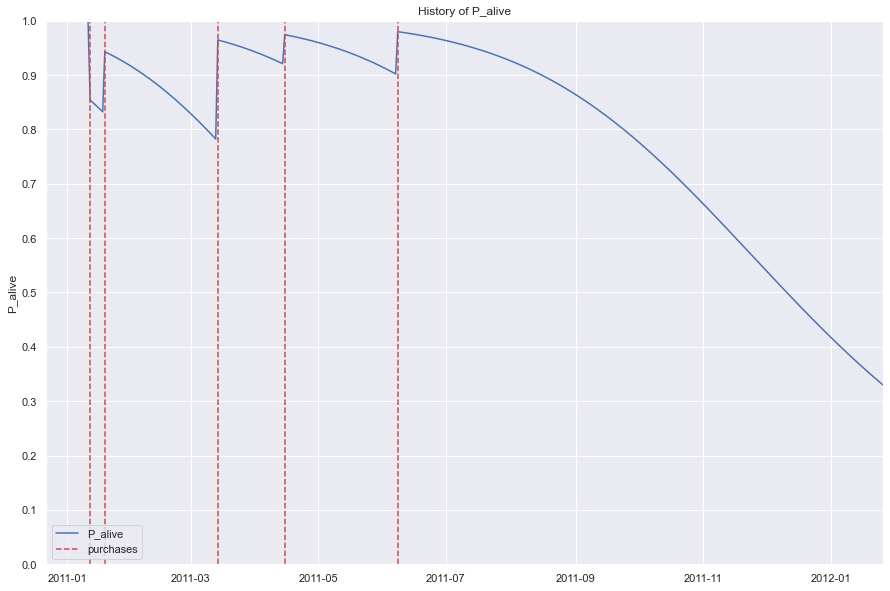

In [25]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt

# clear past visualization instructions
plt.clf()

# customer of interest
CustomerID = 12383

# grab customer's metrics and transaction history
filtered_cal_df=filtered_cal_df.reset_index()
cmetrics_pd = filtered_cal_df[filtered_cal_df['user_id']==CustomerID]
trans_history = df.loc[df['user_id'] == CustomerID]

# calculate age at end of dataset
days_since_birth = 400

# plot history of being "alive"
plot_history_alive(
  bgf, 
  days_since_birth, 
  trans_history, 
  'transaction_date'
  )

From this chart, we can see this customer made his or her first purchase in January 2011 followed by a repeat purchase later that month. There was about a 1-month lull in activity during which the probability of the customer being alive declined slightly but with purchases in March, April and June of that year, the customer sent repeated signals that he or she was engaged. Since that last June purchase, the customer hasn't been seen in our transaction history, and our belief that the customer remains engaged has been dropping though as a moderate pace given the signals previously sent.

How does the model arrive at these probabilities? The exact math is tricky but by plotting the probability of being alive as a heatmap relative to frequency and recency, we can understand the probabilities assigned to the intersections of these two values:

## Finding our best customers

<AxesSubplot:title={'center':'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

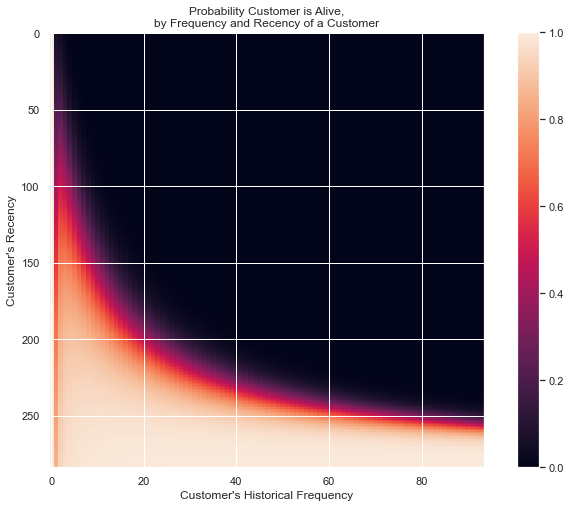

In [26]:
from lifetimes.plotting import plot_probability_alive_matrix

# set figure size
plt.subplots(figsize=(12, 8))

plot_probability_alive_matrix(bgf)


In addition to predicting the probability a customer is still alive, we can calculate the number of purchases expected from a customer over a given future time interval, such as over the next 30-days:

<AxesSubplot:title={'center':'Expected Number of Future Purchases for 30 Units of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

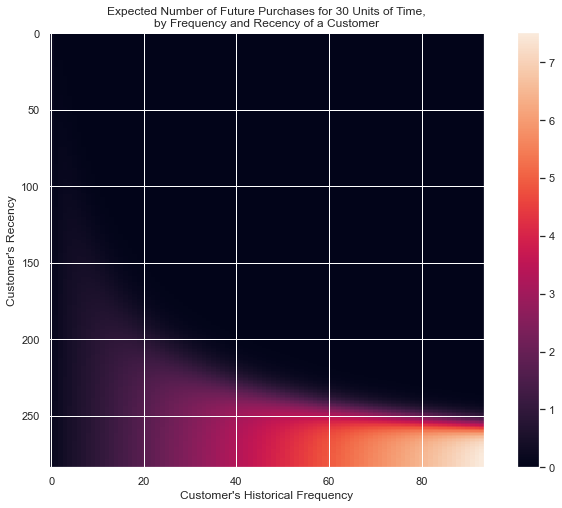

In [27]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf,T=30)

We can see that if a customer has deposited 80 times from you, and their latest deposit was recently, then they are your **Best** customer (bottom-right). Your **coldest customers** are those that are in the top-right corner: they deposited a lot quickly, and we haven’t seen them in weeks.

There’s also a “tail” around (20,200). That represents the customer who deposited infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between transactions. there are our **intermediate** customers

we can calculate this probability for each customer based on their current metrics:

### Predict expected deposit and rank the client in the next period

In [28]:
filtered_df['purchases_next30days']=(
  bgf.conditional_expected_number_of_purchases_up_to_time(
    30, 
    filtered_df['frequency'], 
    filtered_df['recency'], 
    filtered_df['T']
    )
  )

filtered_df.head(10)

,frequency,recency,T,monetary_value,prob_alive,purchases_next30days
user_id,,,,,,
12347,6.0,365.0,367.0,599.701667,0.982823,0.525346
12348,3.0,283.0,358.0,301.480000,0.913008,0.316953
12352,6.0,260.0,296.0,528.361667,0.963896,0.608219
12356,2.0,303.0,325.0,269.905000,0.929323,0.281626
12358,1.0,149.0,150.0,683.200000,0.852424,0.336454
12359,5.0,324.0,331.0,1190.426000,0.977326,0.497766
12360,2.0,148.0,200.0,789.240000,0.878541,0.377873
12362,12.0,292.0,295.0,401.565000,0.991038,1.082186
12363,1.0,133.0,242.0,252.900000,0.620062,0.178668


In [29]:
filtered_df.sort_values(by = 'purchases_next30days').tail(5)

,frequency,recency,T,monetary_value,prob_alive,purchases_next30days
user_id,,,,,,
14606,88.0,372.0,373.0,140.921932,0.998706,5.755312
15311,90.0,373.0,373.0,685.131444,0.998957,5.884305
17841,112.0,372.0,373.0,366.974821,0.998931,7.287152
12748,114.0,373.0,373.0,336.512368,0.999177,7.416525
14911,145.0,372.0,373.0,1065.669793,0.999114,9.393377


## The Gamma-Gamma model For estimating CLV
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency.
how we can measure this relationship between monetary and frequency?

*correlation* The statistical relationship between two variables . A correlation could be positive, meaning both variables move in the same direction, or negative, meaning that when one variable's value increases, the other variables' values decreas

In practice we need to check whether the correlation between the two vectors is close to 0 in order to use this model.


In [30]:
clv_df = metrics_df[metrics_df['frequency']>0]
clv_df[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.002928
frequency,0.002928,1.000000


At this point we can train our Gamma-Gamma submodel.

In [31]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.0)
ggf.fit(clv_df['frequency'],
        clv_df['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2991 subjects, p: 1.11, q: 3.89, v: 936.61>


 Then predict the conditional, expected average lifetime value of our customers.
 This method computes the conditional expectation of the average profit per transaction for customers.

In [32]:
expected_deposit = ggf.conditional_expected_average_profit(
        clv_df['frequency'],
        clv_df['monetary_value']
    )


In [33]:
expected_deposit.head(10)

user_id
12347    526.465061
12348    327.955710
12352    476.772214
12356    320.006738
12358    448.239541
12359    904.780411
12360    545.133369
12362    393.834827
12363    329.165386
12364    289.610333
dtype: float64

then we can estimate the average transaction value and compare this expected value with average profit 

In [34]:
print("Expected conditional average profit: %s, Average profit: %s" % 
( expected_deposit.mean() , clv_df[clv_df['frequency'] > 0]['monetary_value'].mean())
)

Expected conditional average profit: 401.55419373999416, Average profit: 471.7075467375259


In [35]:
ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    metrics_df['frequency'],
    metrics_df['recency'],
    metrics_df['T'],
    metrics_df['monetary_value'],
    time=12, # months
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)

user_id
12346            NaN
12347    3009.238663
12348    1123.270075
12349            NaN
12350            NaN
            ...     
18280            NaN
18281            NaN
18282    1232.960568
18283    2137.416196
18287    1770.571461
Name: clv, Length: 4372, dtype: float64